**Table of contents**<a id='toc0_'></a>    
- [Cleaned Analysis of June 23rd 2023 Flight at 100 Hz](#toc1_)    
  - [Purpose:](#toc1_1_)    
  - [Methods:](#toc1_2_)    
  - [Results](#toc1_3_)    
  - [Naming and Folders](#toc1_4_)    
  - [Importing Packages and Libraries](#toc1_5_)    
  - [Importing Data](#toc1_6_)    
  - [Defining Vehicle Parameters](#toc1_7_)    
  - [Manually Selecting Masks by Plots](#toc1_8_)    
  - [Results of Manual Segmentation](#toc1_9_)    
    - [Acceleration Segments](#toc1_9_1_)    
    - [IMU Calibration Segments](#toc1_9_2_)    
  - [Checking Segments for Good Data](#toc1_10_)    
    - [Plotting Airspeeds, Altitude and Motor RPM for Checks](#toc1_10_1_)    
    - [Showing the Rotational Rate of Vehicle](#toc1_10_2_)    
    - [Calculating Body Accelerations w. Adjustment for g Magnitude](#toc1_10_3_)    
  - [Main Analysis for P_Req](#toc1_11_)    
    - [Power Required without IMU Orientation Adjustment](#toc1_11_1_)    
    - [Lift Measurement without IMU Orientation Adjustment](#toc1_11_2_)    
  - [Collecting Total Results for Polar](#toc1_12_)    
  - [Binning Total Results for Polar](#toc1_13_)    
  - [Plotting Results of Binning](#toc1_14_)    
  - [Performing Curve Fits to Find Polars](#toc1_15_)    
  - [Packaging the Results](#toc1_16_)    
  - [Saving Results to Disk](#toc1_17_)    
  - [Additional Plots](#toc1_18_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Cleaned Analysis of June 23rd 2023 Flight at 100 Hz](#toc0_)

## <a id='toc1_1_'></a>[Purpose:](#toc0_)
* Reduce the code to just the essentials
* Comment on the results

## <a id='toc1_2_'></a>[Methods:](#toc0_)
1. Acceleration method
   1. 

## <a id='toc1_3_'></a>[Results](#toc0_)
Consistent with the uncleaned version, should be valid,  Also, wasn't necessary to include the rate terms unlikely the unclean results, meaning the rate terms in power required are negligible.  

## <a id='toc1_4_'></a>[Naming and Folders](#toc0_)

In [2]:
### Definining name of analysis ###
name = '2023-06-23_CREATeV_Acceleration_Analysis_Cleaned_IMU_NA_MS4525'
data_path = '../../data/'
data_folder = 'createv-2023-06-23'
file_name = '00000012.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## <a id='toc1_5_'></a>[Importing Packages and Libraries](#toc0_)

In [3]:
# Getting packages #
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px

import main
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## <a id='toc1_6_'></a>[Importing Data](#toc0_)

In [4]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2023"
df = main.data_load(data_path, data_folder, file_name, rate, interpolateM, processor)

In [5]:
ct_cruise_segresult_june13 = pd.read_pickle("../Results/2022-06-15_CREATeV_Cruise_Analysis_Cleaned/ct_cruise_segresult.pkl")
build_turbulent = pd.read_pickle("../../DragBuilds/CREATeV_DragBuildTurbulent.pkl")
build_laminar = pd.read_pickle("../../DragBuilds/CREATeV_DragBuildLaminar.pkl")

## <a id='toc1_7_'></a>[Defining Vehicle Parameters](#toc0_)

In [6]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.502
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

## <a id='toc1_8_'></a>[Manually Selecting Masks by Plots](#toc0_)

Using the throttle ramp beginning and end, while looking for when the advance ratio of the propeller is suitable for no singularities.  

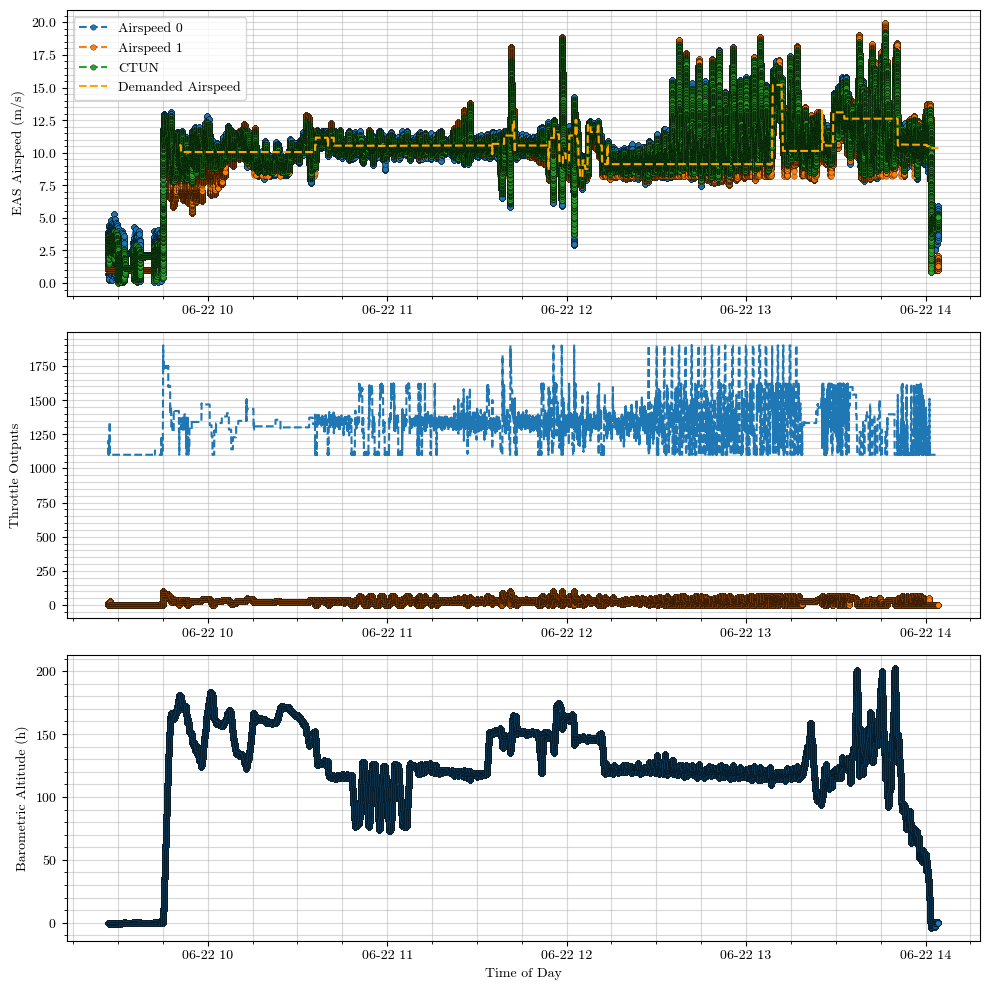

Plot already exists


In [7]:
# Generating Plots for Mask Selection

timeindex_v_thr_h = plt.figure(figsize=(10,10), dpi=100)

df.Airspeed_Sensor1 = np.where(df.Airspeed_Sensor1 < 8.2, df.Airspeed_Sensor1 + 0.976, df.Airspeed_Sensor1)
#df.loc[df.Airspeed_Sensor0 < 8.2, 'Airspeed_Sensor0'] += (9.087 - 8.111)
ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0], label='Airspeed 0')
plt.plot(df.index, df.Airspeed_Sensor1, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0], label='Airspeed 1')
plt.plot(df.index, df.Airspeed_CTUN, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0], label='CTUN')
plt.plot(df.index, df.Airspeed_Demanded, color='orange', linestyle='--', marker='', label="Demanded Airspeed")
plt.legend(loc='upper left')
plt.ylabel("EAS Airspeed (m/s)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ThrottleOut, linestyle='--', marker='', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Throttle Outputs")
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_BARO_0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Barometric Altitude (h)")
plt.xlabel("Time of Day")
plt.grid("On")
plt.show()
main.save_figure(timeindex_v_thr_h, f'{timeindex_v_thr_h=}'.split('=')[0], figure_path)

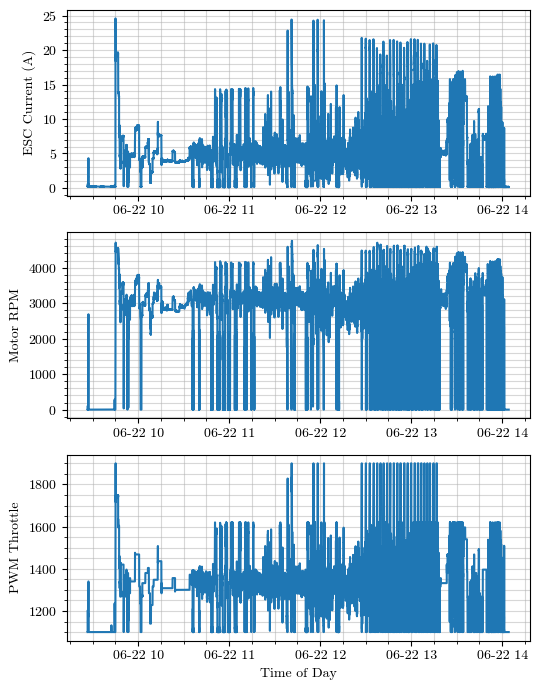

Plot already exists


In [8]:
# Plotting Propulsion Information for Mask Selection
timeindex_I_RPM_thr = plt.figure(figsize=(5.5,7), dpi=100)

ax0 = plt.subplot(3,1,1)
ax0.plot(df.index, df.MainBatteryCurrent, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])
ax0.set_ylabel("ESC Current (A)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
ax1.plot(df.index, df.MotorRPM, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])
ax1.set_ylabel("Motor RPM")
ax2 = plt.subplot(3,1,3, sharex=ax0)
ax2.plot(df.index, df.ThrottleOut, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])
ax2.set_ylabel("PWM Throttle")
ax2.set_xlabel("Time of Day")
plt.show()
main.save_figure(timeindex_I_RPM_thr, f'{timeindex_I_RPM_thr=}'.split('=')[0], figure_path)

## <a id='toc1_9_'></a>[Results of Manual Segmentation](#toc0_)

### <a id='toc1_9_1_'></a>[Acceleration Segments](#toc0_)

In [9]:
year = 2023
month = 6
day = 22

# Acceleration Masking from the above figures
seg_times = np.array([['12:27:16','12:27:26'],
                      ['12:29:50','12:30:10'],
                      ['12:32:24','12:32:44'],
                      ['12:34:54','12:35:20'],
                      ['12:37:15','12:37:40'],
                      ['12:39:26','12:39:51'],
                      ['12:41:29','12:41:54'],
                      ['12:43:45','12:44:10'],
                      ['12:45:52','12:46:16'],
                      ['12:48:20','12:48:40'],
                      ['12:50:36','12:50:59'],
                      ['12:52:46','12:53:05'],
                      ['12:55:10','12:55:34'],
                      ['12:57:20','12:57:49'],
                      ['12:59:44','13:00:06'],
                      ['13:02:05','13:02:30'],
                      ['13:04:17','13:04:42'],
                      ['13:06:25','13:06:47'],
                      ['13:08:39','13:08:42'],
                      ['13:10:29','13:10:42'],
                      ['13:12:13','13:12:28'],
                      ['13:14:29','13:14:47'],
                      ['13:16:36','13:16:55']])

masks = cl_finders.get_maskarray(df, seg_times, year, month, day)

### <a id='toc1_9_2_'></a>[IMU Calibration Segments](#toc0_)

In [10]:
seg_zeroing = np.array([['9:42:00','9:44:00']])
calibration_mask = cl_finders.get_maskarray(df, seg_zeroing, year, month, day)

## <a id='toc1_10_'></a>[Checking Segments for Good Data](#toc0_)

Calculating intermediate variables for display

In [11]:
# Calculation of Intermediate Variables

# Gravity
g = 9.807

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
theta = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                      # Altitude
Vd_eas = df["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1    # the true airspeed

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                      # Revolutions per second
i_esc = df["MainBatteryCurrent"].to_numpy()             # Really the ESC voltage and current here
v_esc = df["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Inertial Measurement Unit
xp_acc = df.XAcc_IMU0.to_numpy()                       # Acceleration in X direction of the IMU
yp_acc = df.YAcc_IMU0.to_numpy()                       # Acceleration in Y direction of the IMU
zp_acc = df.ZAcc_IMU0.to_numpy()                       # Acceleration in Z direction of the IMU

gamma = np.arcsin(-Vd_tas/v_tas)
alpha = theta - gamma # gamma + theta

U = v_tas * np.cos(alpha)
V = 0
W = v_tas * np.sin(alpha)

P = df.GyroX_IMU0 
Q = df.GyroY_IMU0
R = df.GyroZ_IMU0

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83147/156148621.py:11: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83147/156148621.py:13: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83147/156148621.py:19: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1    # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_83147/156148621.py:25: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_C

### <a id='toc1_10_1_'></a>[Plotting Airspeeds, Altitude and Motor RPM for Checks](#toc0_)

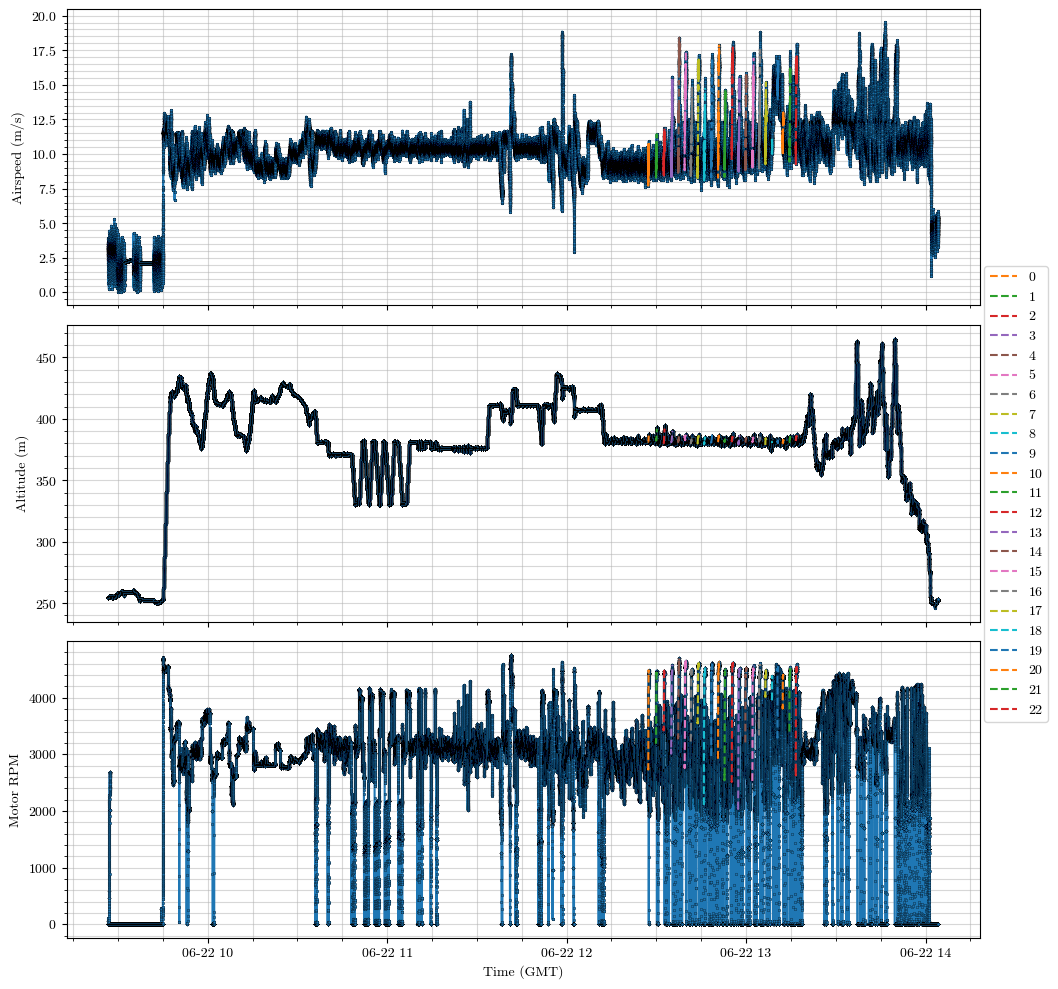

Plot already exists


In [12]:
# Airspeed for Segments
[timeindex_v_h_RPM_fullsegmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

axs[0].plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    axs[0].plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + "")
axs[0].set_ylabel("Airspeed (m/s)")

# Altitude for Segments
axs[1].plot(df.index, df.Altitude_POS)
for i in np.arange(len(masks)):
    axs[1].plot(df.Altitude_POS[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[1].set_ylabel("Altitude (m)")
# axs[1].legend(loc='center left',
#           ncol=2, fancybox=True, bbox_to_anchor=(1.04, 0.5))

# RPM for Segments
axs[2].plot(df.index, df.MotorRPM)
for i in np.arange(len(masks)):
    axs[2].plot(df.MotorRPM[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (GMT)")

timeindex_v_h_RPM_fullsegmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_fullsegmented, f'{timeindex_v_h_RPM_fullsegmented=}'.split('=')[0], figure_path)

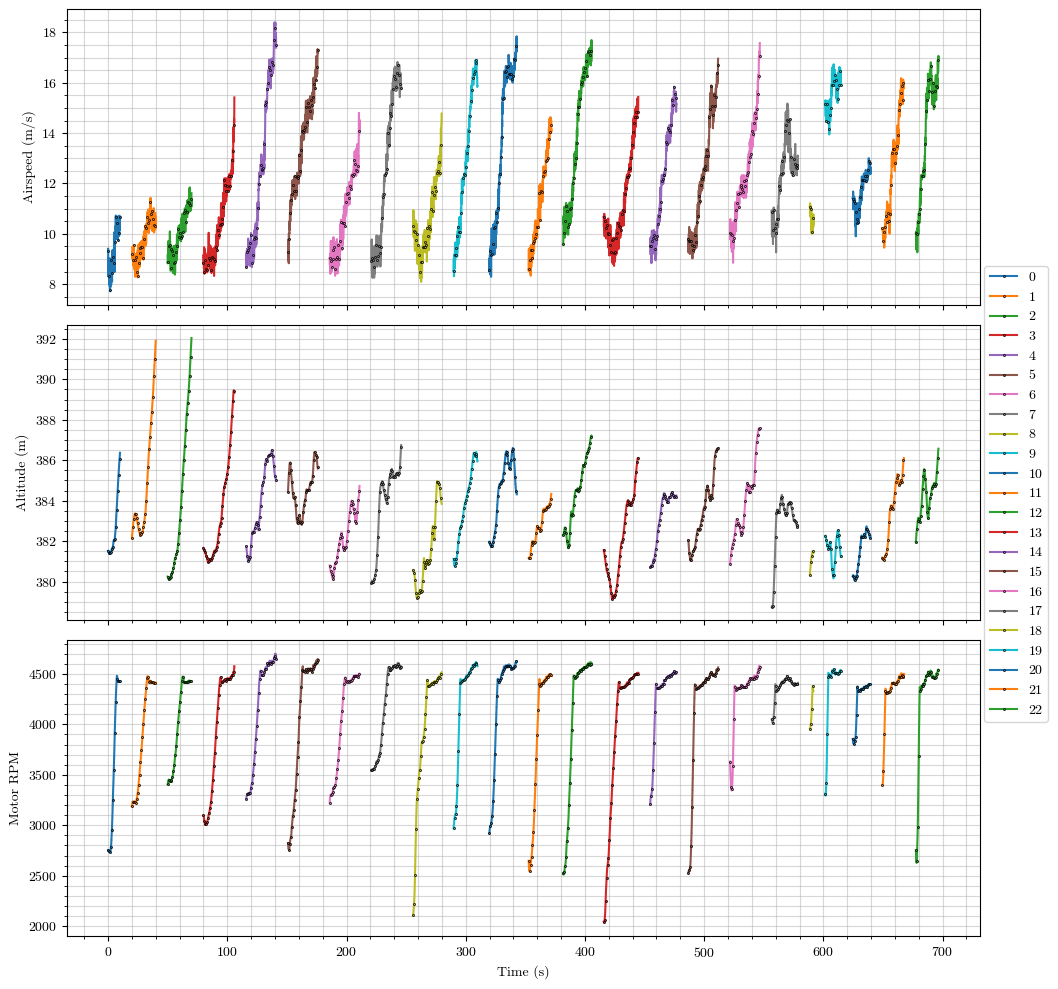

Plot already exists


In [13]:
# Airspeed for Segments
[timeindex_v_h_RPM_segmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs[0].plot(time_s, df.Airspeed_Sensor0[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew,label=str(i) + "")
    # Altitude for Segments
    axs[1].plot(time_s, df.Altitude_POS[masks[i]], linestyle='-' , markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    # RPM for Segments
    axs[2].plot(time_s, df.MotorRPM[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    t_init = time_s[-1]+10
axs[0].set_ylabel("Airspeed (m/s)")
axs[1].set_ylabel("Altitude (m)")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (s)")

timeindex_v_h_RPM_segmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_segmented, f'{timeindex_v_h_RPM_segmented=}'.split('=')[0], figure_path)

### <a id='toc1_10_2_'></a>[Showing the Rotational Rate of Vehicle](#toc0_)

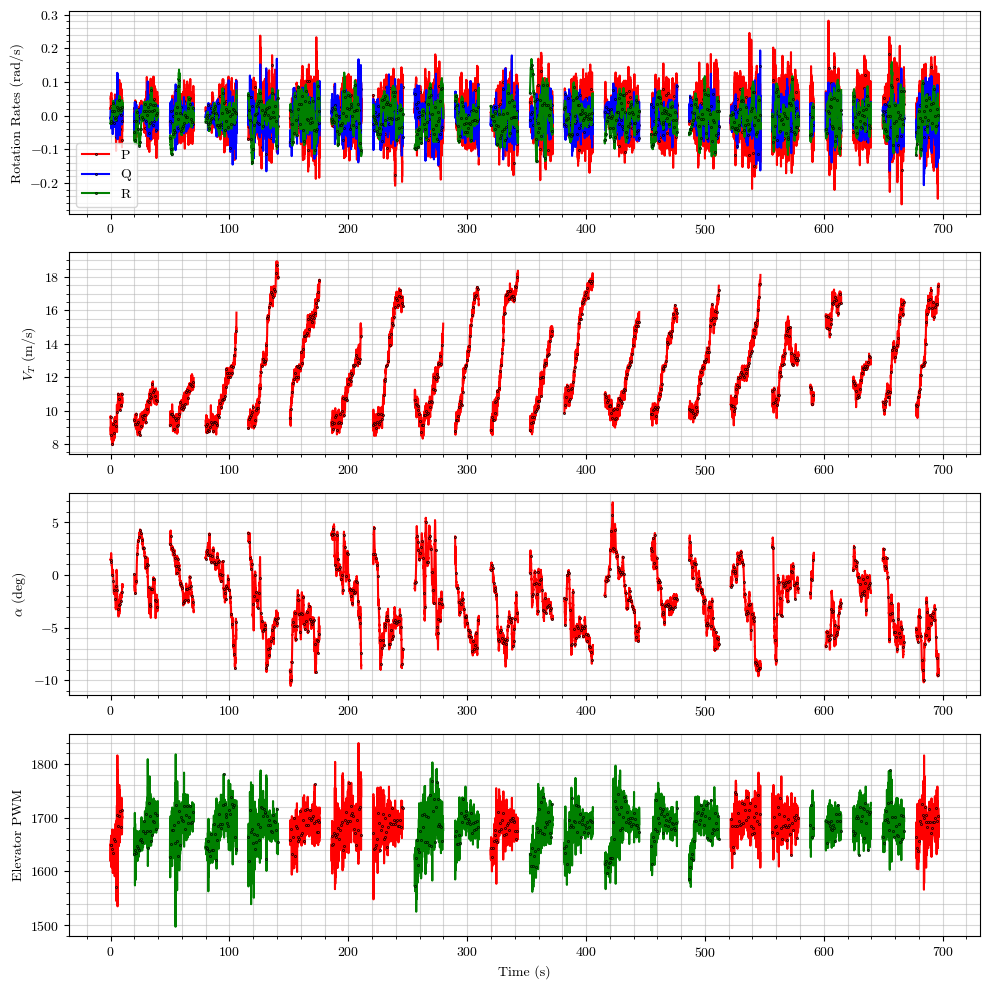

Plot already exists


In [31]:
timeindex_PQR_V_alpha_PWM_segmented = plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0
markerevery=80
markedgew=0.5

bad_selection = [0, 5, 6, 7, 10, 16, 17, 22]

ax1 = plt.subplot(4,1,1)
ax2 = plt.subplot(4,1,2, sharex=ax1)
ax3 = plt.subplot(4,1,3, sharex=ax1)
ax4 = plt.subplot(4,1,4, sharex=ax1)
for i in range(len(masks)):
    dT = 0.01
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    ax1.plot(time_s, P[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[masks[i]], color='b', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    if i == 0:
        ax1.legend()
    ax1.set_ylabel("Rotation Rates (rad/s)")
    ax2.plot(time_s, v_tas[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax2.set_ylabel("$V_T$ (m/s)")
    ax3.plot(time_s, np.rad2deg(alpha[masks[i]]), color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.set_ylabel("$\\alpha$ (deg)")
    if i in bad_selection:
        ax4.plot(time_s, df.ElevatorOut[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    else:
        ax4.plot(time_s, df.ElevatorOut[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax4.set_ylabel("Elevator PWM")
    ax4.set_xlabel("Time (s)")
    t_init = time_s[-1]+10
plt.show()
main.save_figure(timeindex_PQR_V_alpha_PWM_segmented, f'{timeindex_PQR_V_alpha_PWM_segmented=}'.split('=')[0], figure_path)

### <a id='toc1_10_3_'></a>[Calculating Body Accelerations w. Adjustment for g Magnitude](#toc0_)

In [15]:
IMUtotal = (np.sqrt(xp_acc**2 + yp_acc**2 + zp_acc**2))
g_IMU = np.mean(IMUtotal[calibration_mask[0]])
print(g_IMU)

U_dot = xp_acc - (g_IMU * np.sin(theta))
V_dot = yp_acc + (g_IMU * np.cos(theta) * np.sin(phi))
W_dot = zp_acc + (g_IMU * np.cos(theta) * np.cos(phi))

9.874354152246552


## <a id='toc1_11_'></a>[Main Analysis for P_Req](#toc0_)

### <a id='toc1_11_1_'></a>[Power Required without IMU Orientation Adjustment](#toc0_)

In [16]:
CT = prop.thrust_coeff(J)
T = CT * rho * n**2 * prop.diameter**4


# Power Required Individual Terms
P_req_t1 = (T * v_tas)
P_req_t2 = (mass * g * Vd_tas)
P_req_t3 = -(mass * U_dot * v_tas)
P_req_t4 = -(mass * W_dot * v_tas * alpha)
P_req_t5 = mass * v_tas * (Q*U*alpha - Q*W)
P_req_t6 = mass * v_tas * (R*V - P*V)

P_req_simple = P_req_t1 + P_req_t2 + P_req_t3
P_req_wdot = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4
P_req_rates = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4 + P_req_t5 + P_req_t6

D_simple = P_req_simple / v_tas
D_wdot = P_req_wdot / v_tas
D_rates = P_req_rates / v_tas

CD_simple = D_simple / (0.5 * rho * v_tas**2 * createv.area)
CD_wdot = D_wdot / (0.5 * rho * v_tas**2 * createv.area)
CD_rates = D_rates / (0.5 * rho * v_tas**2 * createv.area)

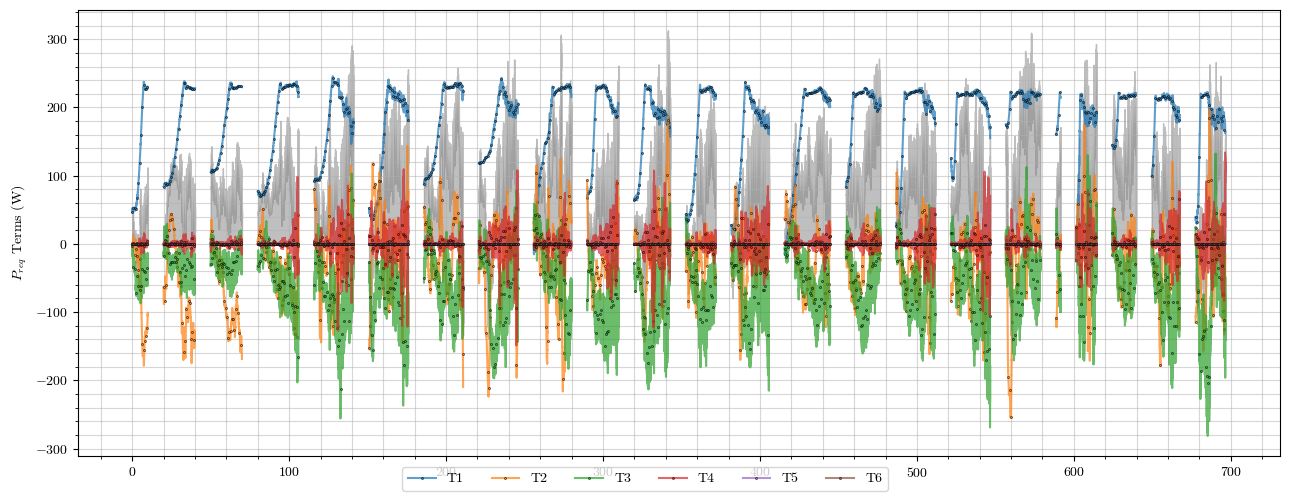

Plot already exists


In [17]:
# Power Required Terms Comparison
[tiemindex_Preq_segmented, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, P_req_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, P_req_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, P_req_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, P_req_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.plot(time_s, P_req_t5[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#9467bd', alpha=0.7)
    axs.plot(time_s, P_req_t6[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#8c564b', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(P_req_wdot[masks[i]])), P_req_wdot[masks[i]], color='grey', alpha=0.5)
    t_init = time_s[-1]+10

tiemindex_Preq_segmented.legend(["T1", "T2", "T3", "T4", "T5", "T6"], loc='lower center', ncol=6)
axs.set_ylabel("$P_{req}$ Terms (W)")

plt.show()
main.save_figure(tiemindex_Preq_segmented, f'{tiemindex_Preq_segmented=}'.split('=')[0], figure_path)

### <a id='toc1_11_2_'></a>[Lift Measurement without IMU Orientation Adjustment](#toc0_)

In [18]:
L_t1 = createv.weight * np.ones(np.shape(W_dot))
L_t2 = -1*(createv.mass * W_dot)
L_t3 = -1*(alpha*T)
L_t4 = alpha*createv.mass*U_dot

L_simple = L_t1 + L_t2
L_full = L_t1 + L_t2 + L_t3 + L_t4

CL_simple = L_simple / (0.5 * rho * v_tas**2 * createv.area)
CL_full = L_full / (0.5 * rho * v_tas**2 * createv.area)
# CL = cl_finders.cl_usbanked(createv, q, phi, W_dot)

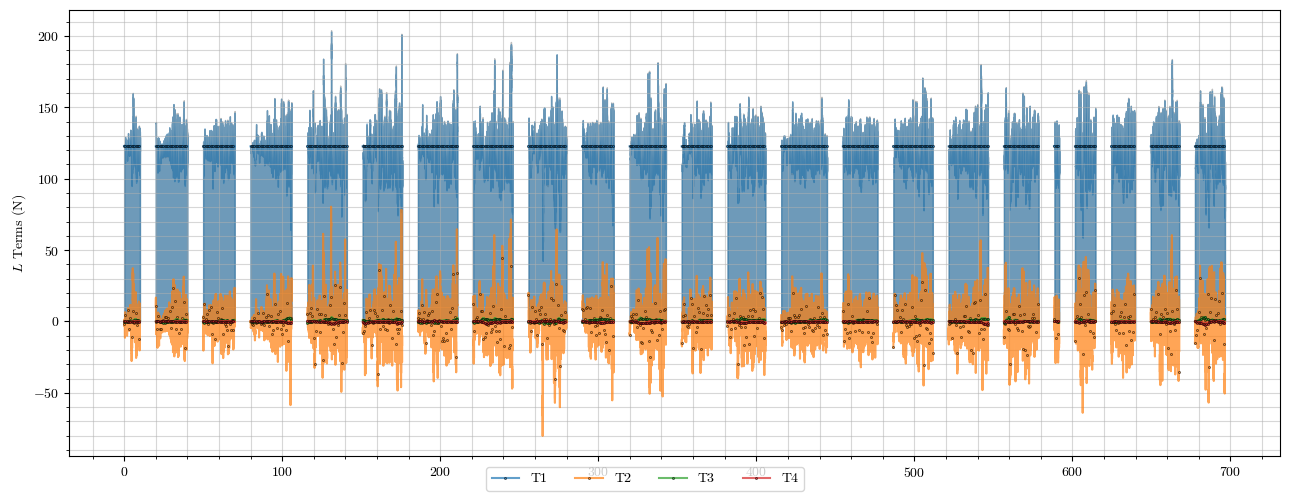

Plot already exists


In [19]:
# Lift Term Comparison
[timeindex_L_segmented, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, L_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, L_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, L_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, L_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(L_full[masks[i]])), L_full[masks[i]], color='grey', alpha=0.5)
    axs.fill_between(time_s, np.zeros(np.shape(L_simple[masks[i]])), L_simple[masks[i]], color='#1f77b4', alpha=0.5)
    t_init = time_s[-1]+10

timeindex_L_segmented.legend(["T1", "T2", "T3", "T4"], loc='lower center', ncol=6)
axs.set_ylabel("$L$ Terms (N)")

plt.show()
main.save_figure(timeindex_L_segmented, f'{timeindex_L_segmented=}'.split('=')[0], figure_path)

## <a id='toc1_12_'></a>[Collecting Total Results for Polar](#toc0_)

In [20]:
# Collecting Total CL, CD's
cl_total = cl_finders.total_segments_boolean(CL_simple, masks)
cd_total = cl_finders.total_segments_boolean(CD_wdot, masks)

In [21]:
# Collecting Total CL, CD for Good Runs
cl_total_goodruns = np.array([])
cd_total_goodruns = np.array([])
selection = np.arange(22)
bad_selection = [0, 5, 6, 7, 10, 16, 17, 22]

for i in selection:
    if i in bad_selection:
        continue
    cl_total_goodruns = np.append(cl_total_goodruns, CL_simple[masks[i]])
    cd_total_goodruns = np.append(cd_total_goodruns, CD_wdot[masks[i]])

## <a id='toc1_13_'></a>[Binning Total Results for Polar](#toc0_)

In [22]:
bins = np.linspace(0.05, 1.4, 50)
[cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_bin_means, cd_bin_stds, cd_bin_ci95s] = cl_finders.collect_bins(np.linspace(0.2, 1.1, 50), cl_total, cd_total)
[cl_bin_means_good, cl_bin_stds_good, cl_bin_ci95s_good, cd_bin_means_good, cd_bin_stds_good, cd_bin_ci95s_good] = cl_finders.collect_bins(np.linspace(0.2, 1.1, 50), cl_total_goodruns, cd_total_goodruns)

## <a id='toc1_14_'></a>[Plotting Results of Binning](#toc0_)

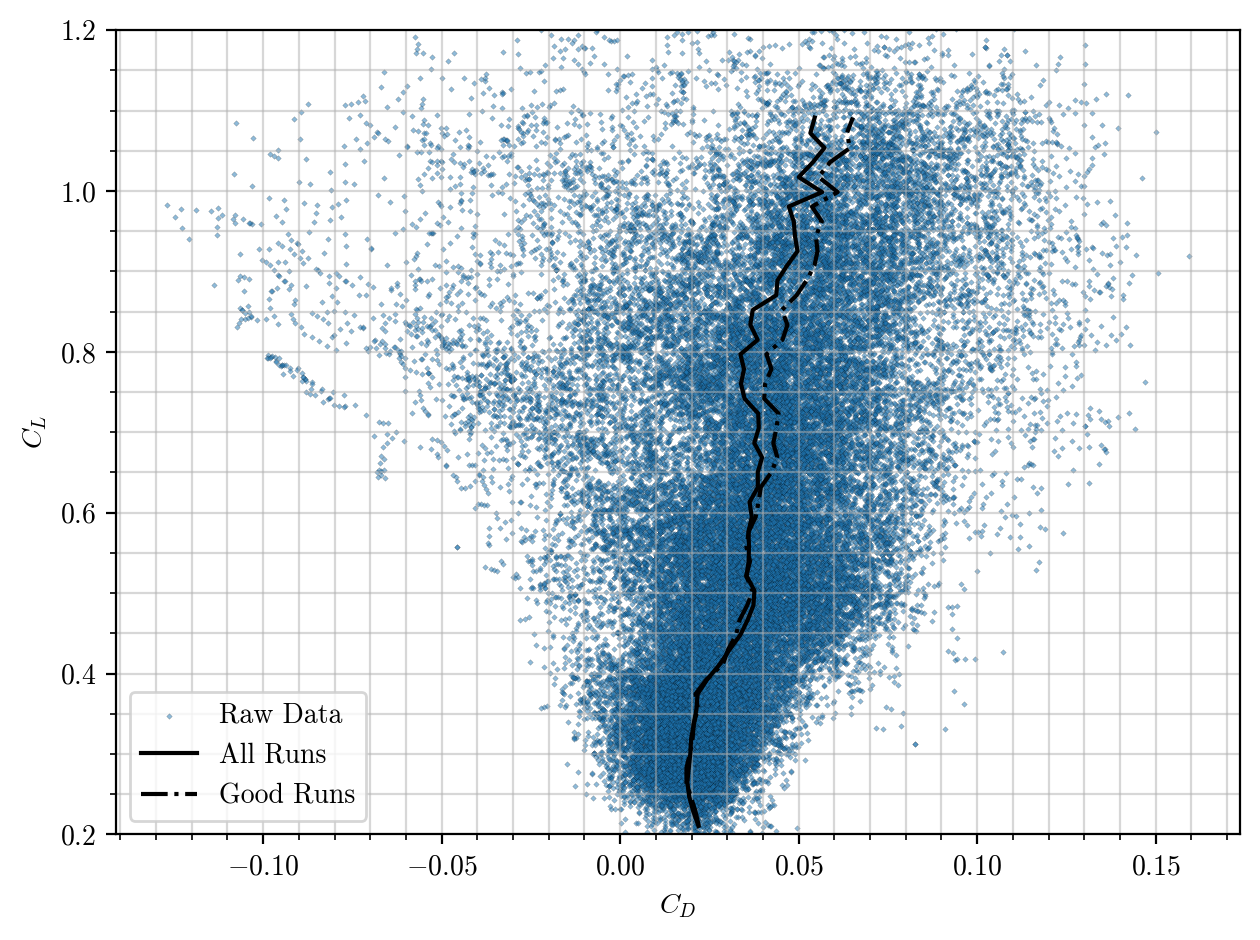

Plot already exists


In [23]:
fig_dragpolar = plt.figure(dpi=200)
plt.scatter(cd_total, cl_total, marker='D', alpha=0.5, edgecolors=[0,0,0], s=2, linewidths=0.1, label='Raw Data')
plt.plot(cd_bin_means, cl_bin_means, marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', color='black', label='All Runs')
plt.plot(cd_bin_means_good, cl_bin_means_good, marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-.', color='black', label='Good Runs')
plt.ylim([0.2, 1.2])
plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.show()
main.save_figure(fig_dragpolar, f'{fig_dragpolar=}'.split('=')[0], figure_path)

## <a id='toc1_15_'></a>[Performing Curve Fits to Find Polars](#toc0_)

In [24]:
polar_acceleration = cl_finders.cd2polar(createv, cd_total, cl_total, highorder=False)
polar_acceleration_good = cl_finders.cd2polar(createv, cd_total_goodruns, cl_total_goodruns, highorder=False)

print(polar_acceleration)
print(polar_acceleration_good)

0.05577856772232892
0.12410737752474377
[0.02322009 0.76128433]
[0.02178431 0.54850082]


## <a id='toc1_16_'></a>[Packaging the Results](#toc0_)

In [25]:
acceleration_binresult = cl_finders.packaging_binresults(cl_total, cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_total, cd_bin_means, cd_bin_stds, cd_bin_ci95s, polar_acceleration, createv)
acceleration_binresult_good = cl_finders.packaging_binresults(cl_total_goodruns, cl_bin_means_good, cl_bin_stds_good, cl_bin_ci95s_good, cd_total_goodruns, cd_bin_means_good, cd_bin_stds_good, cd_bin_ci95s_good, polar_acceleration_good, createv)

## <a id='toc1_17_'></a>[Saving Results to Disk](#toc0_)

In [26]:
# Exporting polar data
pd.to_pickle(acceleration_binresult, result_path+'acceleration_allresult.pkl')
pd.to_pickle(acceleration_binresult_good, result_path+'acceleration_goodresult.pkl')

## <a id='toc1_18_'></a>[Additional Plots](#toc0_)

In [27]:
polar_2022_ct = cl_finders.cd2polar(createv, ct_cruise_segresult_june13.ave_polar.CD, ct_cruise_segresult_june13.ave_polar.CL, highorder=False)

0.1814960984922529


In [28]:
# Fitting only to CL 1.1 and less

[CL_fitted_CT, CD_fitted_CT] = cl_finders.plotfittedpolar(createv, polar_2022_ct, [0.2, 1.1])
[CL_fitted_ACC, CD_fitted_ACC] = cl_finders.plotfittedpolar(createv, polar_acceleration, [0.2, 1.1])

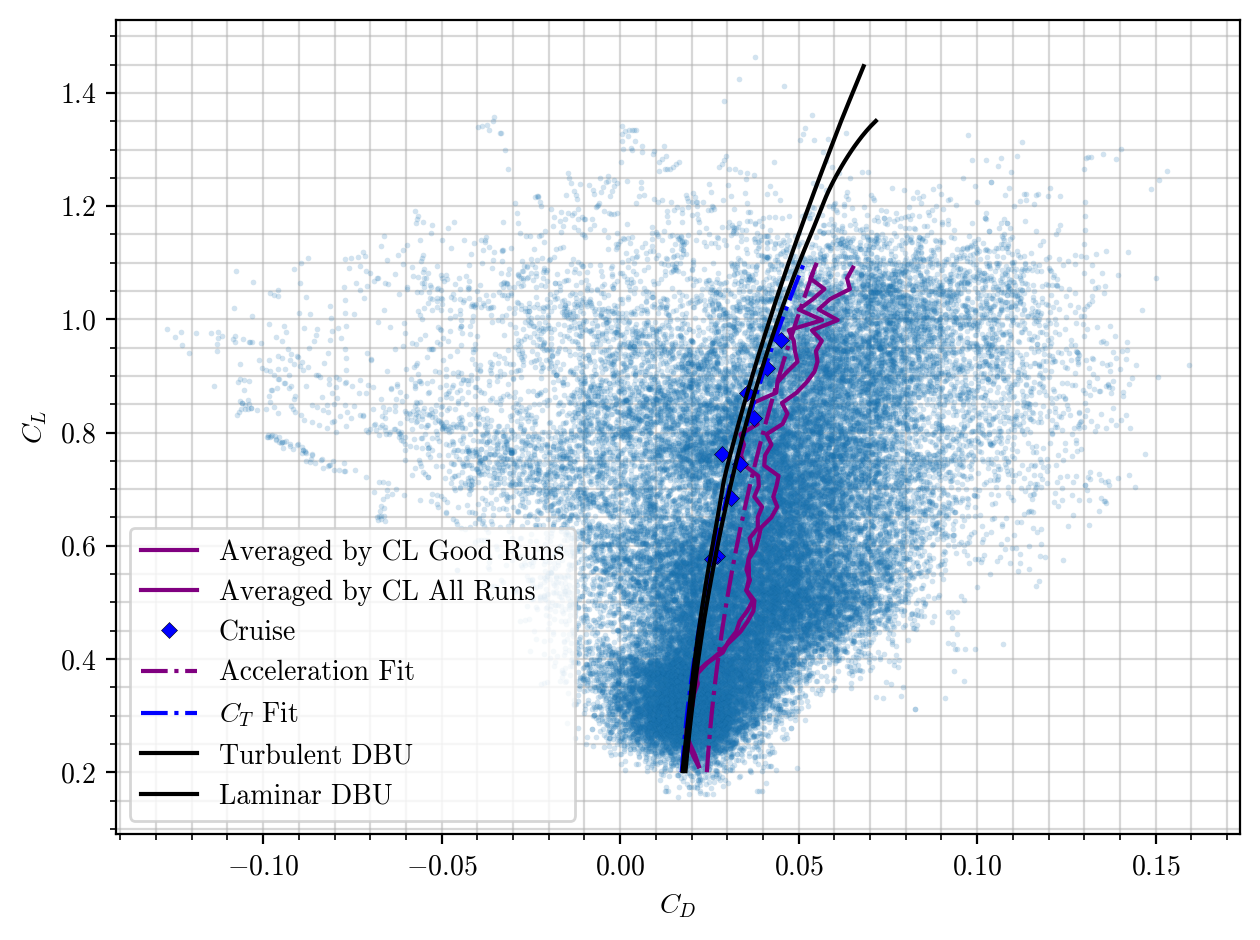

Plot already exists


In [29]:
fig_dragpolar_context = plt.figure(dpi=200)

plt.plot(cd_total, cl_total, marker="o", markersize=2, markeredgewidth=0.01, markeredgecolor='black', linestyle='', alpha=0.2)
plt.plot(cd_bin_means_good, cl_bin_means_good, marker='', color='purple', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', label='Averaged by CL Good Runs')
plt.plot(cd_bin_means, cl_bin_means, marker='', color='purple', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', label='Averaged by CL All Runs')

plt.plot(ct_cruise_segresult_june13.ave_polar.CD, ct_cruise_segresult_june13.ave_polar.CL, marker='D', color='blue', linestyle='', label="Cruise")

plt.plot(CD_fitted_ACC, CL_fitted_ACC, marker='', color='purple', linestyle='-.', label="Acceleration Fit")
plt.plot(CD_fitted_CT, CL_fitted_CT, marker='', color='blue', linestyle='-.', label="$C_T$ Fit")

plt.plot(build_turbulent.CD, build_turbulent.CL, marker='', color='black', linestyle='solid', label="Turbulent DBU")
plt.plot(build_laminar.CD, build_laminar.CL, marker='', color='black', linestyle='solid', label="Laminar DBU")

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.show()
main.save_figure(fig_dragpolar_context, f'{fig_dragpolar_context=}'.split('=')[0], figure_path)

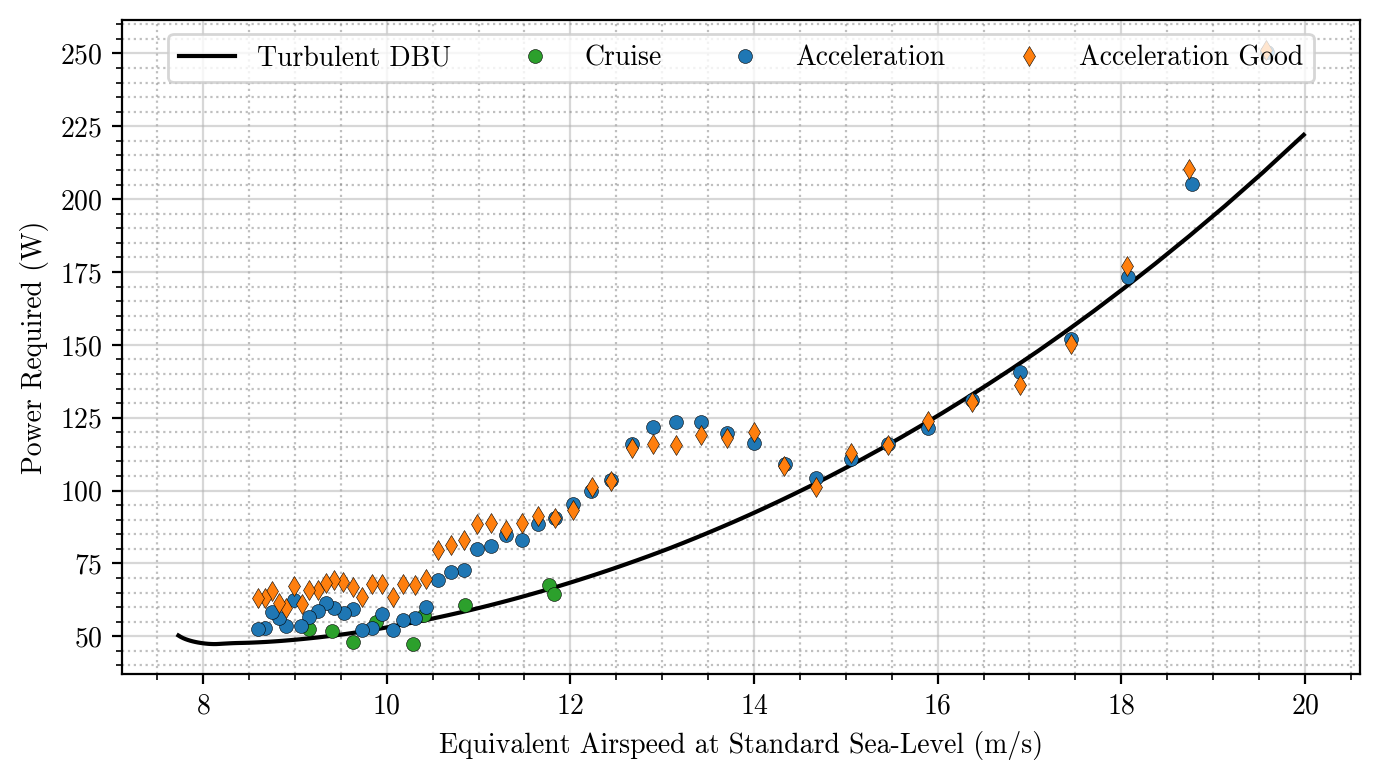

In [30]:
# Plot of Power Required Fits and Data #

[Pbin_acc, EAS_acc] = cl_finders.rawpolar2preqew(createv, cl_bin_means, cd_bin_means)
[Pbin_accgood, EAS_accgood] = cl_finders.rawpolar2preqew(createv, cl_bin_means_good, cd_bin_means_good)
[P_dbu, EAS_dbu] = cl_finders.rawpolar2preqew(createv, build_turbulent.CL, build_turbulent.CD)
[P_ct, EAS_ct] = cl_finders.rawpolar2preqew(createv, ct_cruise_segresult_june13.ave_polar.CL, ct_cruise_segresult_june13.ave_polar.CD)

fig_Preq_context = plt.figure(figsize=(7,4), dpi=200)
plt.errorbar(EAS_acc, Pbin_acc, label="Acceleration", linestyle='', marker='o', markersize=5)
plt.errorbar(EAS_accgood, Pbin_accgood , label="Acceleration Good", linestyle='', marker='d', markersize=5)
plt.plot(EAS_dbu, P_dbu, marker='', color='black', label='Turbulent DBU')
plt.plot(EAS_ct, P_ct, label='Cruise', linestyle='', marker='o', markersize=5)

plt.xlabel("Equivalent Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.legend(loc='upper center', ncol=4)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout()
plt.show()
main.save_figure(fig_Preq_context, f'{fig_Preq_context=}'.split('=')[0], figure_path, overwrite=True)